<a href="https://colab.research.google.com/github/alirezaght/bitcoin-price-prediction/blob/main/ethAndBtc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download historical data

I'm downloading btc price from https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_d.csv

and eth price from https://www.cryptodatadownload.com/cdd/Bitstamp_ETHUSD_d.csv

and gold price from https://www.nasdaq.com/market-activity/commodities/gc:cmx/historical

In [2]:
!gdown 1Vx3NGEQNssg03QXXlIjtFDjMC_8Vm9Hr
!gdown 1Ih-kXFor9L3YSQYJPdh7XRnuqbPt34Hv

Downloading...
From: https://drive.google.com/uc?id=1Vx3NGEQNssg03QXXlIjtFDjMC_8Vm9Hr
To: /content/btc-price.csv
100% 285k/285k [00:00<00:00, 75.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ih-kXFor9L3YSQYJPdh7XRnuqbPt34Hv
To: /content/eth-price.csv
100% 186k/186k [00:00<00:00, 77.1MB/s]


# Preprocess *data*

In [23]:
from tensorflow.python.ops.ragged.row_partition import np
from functools import reduce 
import pandas as pd
from datetime import datetime

btc_csv = pd.read_csv('btc-price.csv')
eth_csv = pd.read_csv('eth-price.csv')

if len(btc_csv) != len(eth_csv):
  print("WARNING. Length are different!")



original = []

for i in range(1, min(len(btc_csv), len(eth_csv))):
  if i >= len(btc_csv) or i >= len(eth_csv):
    break  
  
  btc_price = float(btc_csv.iloc[i].name[3]) # open price    
  eth_price = float(eth_csv.iloc[i].name[3]) # open price  
  original.append([btc_price, eth_price])

original = np.array(original)


WARNING. Length are different!


# Scaling

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(original)

x_train = []
y_train = []
for i in range(90, len(data)):
  x_train.append(np.reshape(data[i - 90: i], (1, 180)))
  y_train.append([data[i][0], data[i][1]])


x_train = np.reshape(x_train, (len(x_train), 90, 2))
y_train = np.reshape(y_train, (len(y_train), 2))


# Build Model and Train

In [25]:
from tensorflow.keras import layers
from tensorflow import keras


model = keras.Sequential()

model.add(layers.LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 2)))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(50, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(50, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(50))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = 2))

model.compile(optimizer="adam", loss="mse")
model.fit(x_train, y_train, epochs=30, batch_size=32)
model.summary()

Epoch 1/30
55/55 [==============================] - 19s 199ms/step - loss: 0.0171
Epoch 2/30
55/55 [==============================] - 13s 238ms/step - loss: 0.0060
Epoch 3/30
55/55 [==============================] - 14s 249ms/step - loss: 0.0052
Epoch 4/30
55/55 [==============================] - 13s 232ms/step - loss: 0.0044
Epoch 5/30
55/55 [==============================] - 15s 283ms/step - loss: 0.0041
Epoch 6/30
55/55 [==============================] - 12s 216ms/step - loss: 0.0038
Epoch 7/30
55/55 [==============================] - 14s 256ms/step - loss: 0.0037
Epoch 8/30
55/55 [==============================] - 10s 190ms/step - loss: 0.0037
Epoch 9/30
55/55 [==============================] - 10s 190ms/step - loss: 0.0034
Epoch 10/30
55/55 [==============================] - 15s 265ms/step - loss: 0.0035
Epoch 11/30
55/55 [==============================] - 12s 218ms/step - loss: 0.0032
Epoch 12/30
55/55 [==============================] - 10s 190ms/step - loss: 0.0030
Epoch 13/30
5

# Predict

1/1 [==============================] - 0s 37ms/step
0.40952224873027154
0.7662580543032778


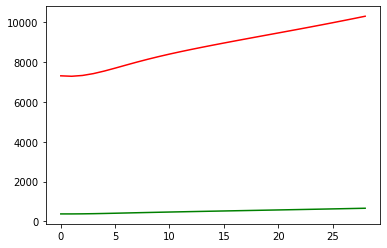

In [42]:
import matplotlib.pyplot as plt

x = np.array([])
x = np.append(x, original[len(original) - 90: len(original)])
x = np.reshape(x, (90, 2))
x = scaler.transform(x)
x = np.reshape(x, (1, 90, 2))
res_array = np.array([])
btc_array = np.array([])
eth_array = np.array([])
for i in range(1, 30):
  res = scaler.inverse_transform(model.predict(x))  
  btc_array = np.append(btc_array, res[0][0])
  eth_array = np.append(eth_array, res[0][1])
  res_array = np.append(res_array, res)  
  x = np.array([])
  x = np.append(x, np.append(original[len(original) - 90 + i: len(original)], res_array))
  x = np.reshape(x, (90, 2))
  x = scaler.transform(x)
  x = np.reshape(x, (1, 90, 2))


plt.plot(eth_array, color='green')
plt.plot(btc_array, color='red')
print((btc_array[len(btc_array) - 1] - btc_array[0])/btc_array[0])
print((eth_array[len(eth_array) - 1] - eth_array[0])/eth_array[0])